In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict
from sklearn.model_selection import KFold

from mapie.regression import MapieQuantileRegressor
from mapie.metrics import regression_coverage_score

Data are some simple synthetic galaxy spectra generated a few years ago for this paper, using BAGPIPES. There are spectra with 850 wavelengths, and we want to reconstruct some physical properties: age, star formation history timescale, dust content in a simple screen model, and stellar mass. We'll use age here as it's one of the trickiest properties to predict.

In [2]:
features = pd.read_csv('spectra.csv', header=None, sep = ' ')

In [3]:
features.head()

,0,1,2,3,4,5,6,7,8,9,...,840,841,842,843,844,845,846,847,848,849
0,0.010532,0.011854,0.011477,0.011186,0.010723,0.007781,0.003281,0.007836,0.008751,0.012667,...,0.024035,0.023810,0.024046,0.023865,0.023751,0.023780,0.023700,0.023532,0.023523,0.023560
1,0.012205,0.013479,0.013350,0.013067,0.013404,0.011026,0.005107,0.011005,0.012001,0.014975,...,0.045495,0.044942,0.045321,0.044943,0.044721,0.044843,0.044598,0.043910,0.043594,0.043794
2,0.003660,0.004010,0.004001,0.003920,0.004109,0.003515,0.001691,0.003498,0.003792,0.004505,...,0.016169,0.015951,0.016057,0.015907,0.015811,0.015818,0.015722,0.015475,0.015348,0.015374
3,0.065447,0.071665,0.071253,0.069657,0.072569,0.061464,0.029246,0.060936,0.065971,0.078945,...,0.052733,0.051933,0.052260,0.051681,0.051270,0.051238,0.050767,0.049791,0.049233,0.049177
4,0.143073,0.156413,0.155725,0.152241,0.159254,0.135972,0.065265,0.134719,0.145695,0.172647,...,0.071784,0.070843,0.071313,0.070579,0.070022,0.069911,0.069362,0.068354,0.067859,0.067661


In [4]:
target = pd.read_csv('GalaxyProperties.csv')

In [5]:
target.head()

,Unnamed: 0,Dust attenuation value,Age (Gyr),Log10(Mass/Mass_Sun),Tau (Gyr)
0,0,0.164869,0.203291,7.885367,0.033035
1,1,0.200852,0.470248,8.297678,0.087146
2,2,0.197863,4.033993,8.184615,1.273974
3,3,0.001000,0.721636,8.360110,0.242588
4,4,0.001000,0.699464,8.373327,0.510683


In [6]:
features.shape

(1000, 850)

In [7]:
#Our goal will be to predict log(age), which empirically works better than Age

log_age = np.log(target['Age (Gyr)'].values) 

We split data into into train, calibration and validation sets (using train_test_split function twice), and run a regression model that outputs point predictions:

In [8]:
X_train, X_test, y_train, y_test = train_test_split(features, log_age, test_size=0.33, random_state=10)

X_calib, X_val, y_calib, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=10)

n = len(y_calib)

n_val = len(y_val)

#Train model

model = RandomForestRegressor(random_state=10)

model.fit(X_train, y_train)


RandomForestRegressor(random_state=10)

### Simplest version of conformal predictions - generating intervals from point predictions.

We can predict the labels for the calibration set and visualize absolute residuals:

In [9]:
y_calib_pred = model.predict(X_calib)

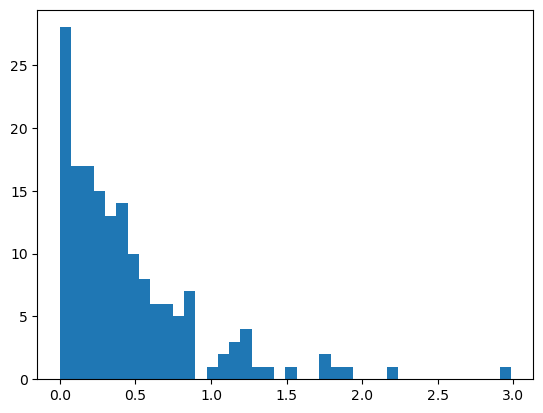

In [10]:
plt.hist(np.abs(y_calib_pred - y_calib), bins = 40);

Let's say that we are interested in 80% coverage; alpha = 0.2. We find the corresponding 80% quantile of the absolute residuals, with the usual finite sample size correction:

In [11]:
alpha = 0.2

In [12]:
qhat = np.quantile(np.abs(y_calib_pred - y_calib), np.ceil((n+1)*(1-alpha))/n)

In [13]:
qhat

0.7055971501774867

We can now generate intervals by adding this quantity on either side of the point predictions:

In [14]:
intervals = np.hstack([(y_calib_pred - qhat).reshape(-1,1), (y_calib_pred + qhat).reshape(-1,1)])

#### To check calibration, we ask how often the true value is found in the intervals:

In [15]:
#whether true value is in interval

inint = np.array([intervals[i][0] < y_calib[i] < intervals[i][1] for i in range(len(y_calib))], dtype = int)

In [16]:
inint.mean() #Success! (Coverage is as expected)

0.806060606060606

We should also check that the coverage holds on the validation set:

In [17]:
y_val_pred = model.predict(X_val)
intervals_val = np.hstack([(y_val_pred - qhat).reshape(-1,1), (y_val_pred + qhat).reshape(-1,1)])
inint_val = np.array([intervals_val[i][0] < y_val[i] < intervals_val[i][1] for i in range(len(y_val))], dtype = int)
inint_val = np.array([intervals_val[i][0] < y_val[i] < intervals_val[i][1] for i in range(len(y_val))], dtype = int)
inint_val.mean() #Not bad! Should also marginalize over effect of split of data etc.

0.8363636363636363

### Conformalized Quantile Regression

We need to start with a model that can output quantile intervals, so we use conformalization to calibrate them.

Here we use GradientBoostingRegression with quantile loss.

Read about quantile loss:

https://towardsdatascience.com/quantile-loss-and-quantile-regression-b0689c13f54d

Example partially taken from: 

https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_quantile.html

and

https://mapie.readthedocs.io/en/latest/examples_regression/1-quickstart/plot_prefit.html

Usage note: check data for irregularities in target distribution, which may affect the quantiles.

In [18]:
all_models = {}

for alpha in [0.05, 0.1, 0.5, 0.9, 0.95]:
    gbr = GradientBoostingRegressor(loss = "quantile", alpha = alpha)
    all_models["q %1.2f" % alpha] = gbr.fit(X_train, y_train)

In [19]:
all_models

{'q 0.05': GradientBoostingRegressor(alpha=0.05, loss='quantile'),
 'q 0.10': GradientBoostingRegressor(alpha=0.1, loss='quantile'),
 'q 0.50': GradientBoostingRegressor(alpha=0.5, loss='quantile'),
 'q 0.90': GradientBoostingRegressor(loss='quantile'),
 'q 0.95': GradientBoostingRegressor(alpha=0.95, loss='quantile')}

Let's compute the conformal scores s(x,y) using alpha = 0.1 and 0.9 as quantiles (for 80% coverage), on the calibration set:

In [20]:
y_pred_cal_q_hi = all_models["q 0.90"].predict(X_calib) 

y_pred_cal_q_lo = all_models["q 0.10"].predict(X_calib) 

In [21]:
intervals = np.hstack([y_pred_cal_q_lo.reshape(-1,1), y_pred_cal_q_hi.reshape(-1,1)])

The spread in the width of the intervals shows the natural adaptivity for quantile regression:

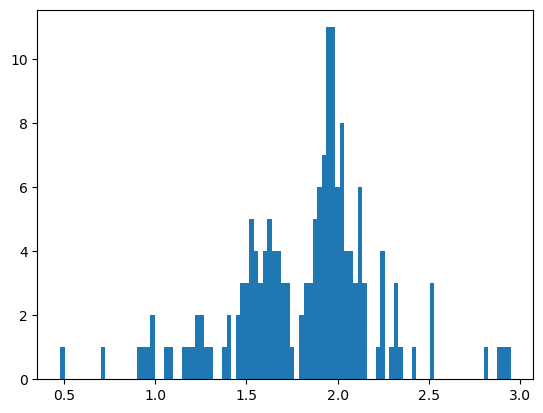

In [22]:
plt.hist(y_pred_cal_q_hi-y_pred_cal_q_lo, bins = 100);

This below is just a visualization of true values vs predicted intervals:

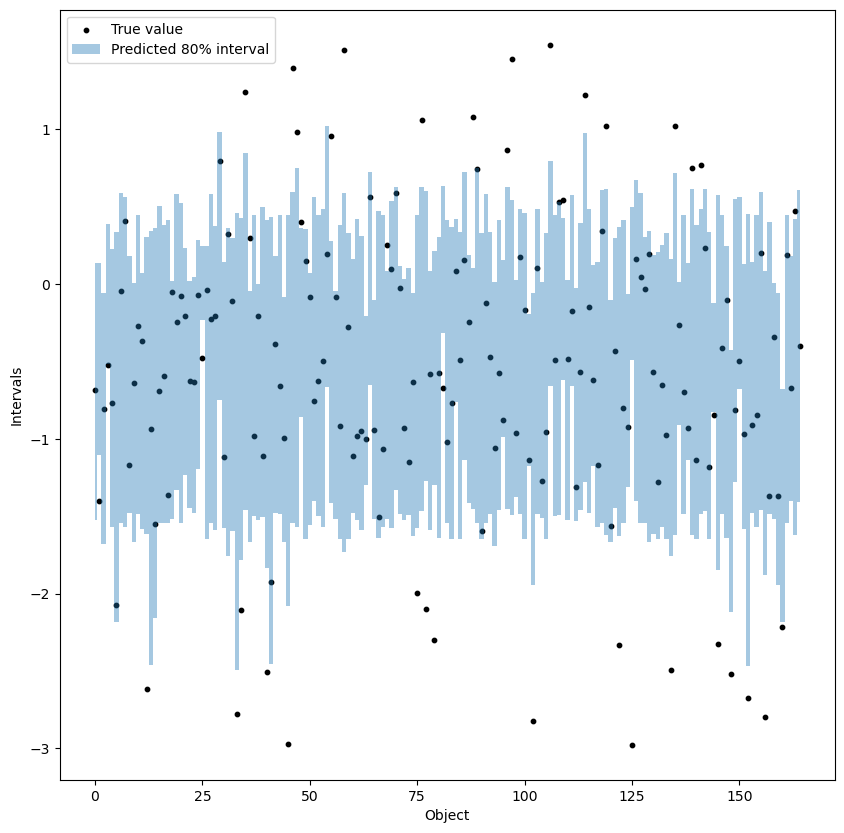

In [23]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(range(len(y_calib)), y_calib, c ='k', s = 10, label = "True value")
plt.fill_between(
    range(len(y_calib)), y_pred_cal_q_lo, y_pred_cal_q_hi, step = 'mid', alpha=0.4, label="Predicted 80% interval"
)
plt.xlabel("Object")
plt.ylabel("Intervals")
plt.legend(loc="upper left")
plt.show()

#### More formally, we can ask: what fraction of true values lies in the 80% region?

In [24]:
inint = np.array([intervals[i][0] < y_calib[i] < intervals[i][1] for i in range(len(y_calib))], dtype = int)

In [25]:
inint.mean() #Target: 0.80

0.7393939393939394

### Calibration:

These below are the conformal scores for conformal quantile regression (for 80% coverage, i.e. 10/90 quantiles):

In [26]:
s10_90 = np.array([max(y_pred_cal_q_lo[i] - y_calib[i], y_calib[i] - y_pred_cal_q_hi[i]) for i in range(len(y_calib))])

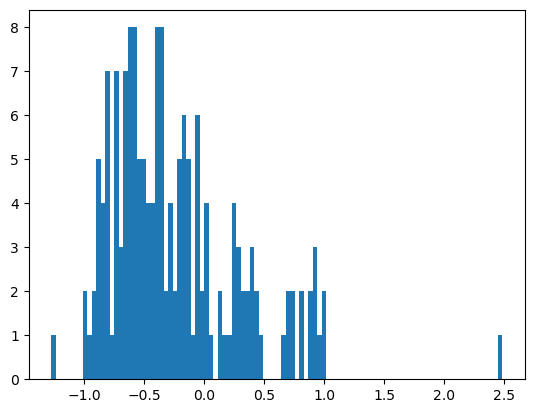

In [27]:
#We can take a look at the scores distribution:

plt.hist(s10_90, bins = 100);

In [28]:
# Get the score quantile for alpha = 0.2 (corresponding to 80% coverage, i.e. quantiles 0.1 and 0.9)

alpha = 0.2

correction = np.quantile(s10_90, np.ceil((n+1)*(1-alpha))/n, method='higher')

Now we build the new intervals by applying the correction:

In [29]:
intervals_10_90 = np.hstack([(intervals[:,0] - correction).reshape(-1,1), (intervals[:,1] + correction).reshape(-1,1)])

In [30]:
inint_10_90 = np.array([intervals_10_90[i][0] < y_calib[i] < intervals_10_90[i][1] for i in range(len(y_calib))], dtype = int)

In [31]:
inint_10_90.mean() #Success!

0.806060606060606

Finally, we can apply the same correction to the validation set:

In [32]:
y_pred_val_q_hi = all_models["q 0.90"].predict(X_val) 

y_pred_val_q_lo = all_models["q 0.10"].predict(X_val) 

intervals = np.hstack([y_pred_val_q_lo.reshape(-1,1), y_pred_val_q_hi.reshape(-1,1)]) # original

intervals_10_90 = np.hstack([(intervals[:,0] - correction).reshape(-1,1), (intervals[:,1] + correction).reshape(-1,1)])

inint_10_90 = np.array([intervals_10_90[i][0] < y_val[i] < intervals_10_90[i][1] for i in range(len(y_val))], dtype = int)

inint_10_90.mean() #Target: 0.80

0.8606060606060606

#### We can also do the same thing with MAPIE:

In [33]:
# Calibrate uncertainties on calibration set
mapie_cqr = MapieQuantileRegressor([all_models["q 0.10"], all_models["q 0.90"], all_models["q 0.50"]], cv="prefit", alpha=0.2)

mapie_cqr.fit(X_calib, y_calib)

# Evaluate prediction and coverage level on calibration set
y_pred_cqr, y_pis_cqr = mapie_cqr.predict(X_calib)
coverage_cqr = regression_coverage_score(
    y_calib,
    y_pis_cqr[:, 0, 0],
    y_pis_cqr[:, 1, 0]
)

print('Coverage on calibration set:', '%.2f' % coverage_cqr)

# Evaluate prediction and coverage level on testing set
y_pred_cqr, y_pis_cqr = mapie_cqr.predict(X_val)
coverage_cqr = regression_coverage_score(
    y_val,
    y_pis_cqr[:, 0, 0],
    y_pis_cqr[:, 1, 0]
)

print('Coverage on validation set:', '%.2f' %  coverage_cqr) #Very similar

Coverage on calibration set: 0.81
Coverage on validation set: 0.86


/Users/vivi/anaconda3/lib/python3.11/site-packages/mapie/regression/quantile_regression.py:201: UserWarning: WARNING: The alpha that is set needs to be the same as the alpha of your prefitted model in the following order [alpha/2, 1 - alpha/2, 0.5]
  warnings.warn(
/Users/vivi/anaconda3/lib/python3.11/site-packages/mapie/utils.py:598: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(
/Users/vivi/anaconda3/lib/python3.11/site-packages/mapie/utils.py:598: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(
/Users/vivi/anaconda3/lib/python3.11/site-packages/mapie/utils.py:598: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(
/Users/vivi/anaconda3/lib/python3.11/site-packages/mapie/utils.py:598: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(
/Users/vivi/anaconda3/lib/python3.11/site-packages/mapie/utils.py:598: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(
/Users/vivi/anaconda3/li